# **Pneumonia identification from X-Ray images**

#### Teams: Carlos Relaño Rupérez, Javier Rubio Serrano and Javier López Rodríguez

## **Introduction**

Pneumonia is an infection that inflames the air sacs in one or both lungs, and a major cause of morbidity and death in susceptible populations such as infants and elder people. Properly diagnosing this disease can make a difference in its treatment and outcome.

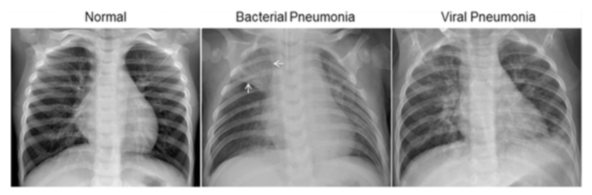

Taking into acount the importance of reliable diagnostics, we will develop an image classifier that is able to distinguish between X-ray images from healthy and pneumonia patients.

Our aim is to perform **Transfer Learning** using a pre-trained Keras deep learning model, transfering the knowledge of that pre-trained model to our new model in order to adapt it to our problem.

We are choosing this option because the Kaggle Xray dataset has too little data to train a full-scale neural network model and get good results with it.

The pre-trained model we're using is **InceptionV3** (https://arxiv.org/abs/1512.00567, https://keras.io/api/applications/inceptionv3/). It is a Neural Network architecture that was an important milestone in the field of Computer Vision. InceptionV3 can be used to classify images, and that is why we're using it for our problem.

There are other Neural Networks that were created after InceptionV3 that would probably give better results (InceptionV4, Inception-ResNet, and many other examples). However, we think that InceptionV3 is a good enough model for our task.

The model will be created using the **Keras Functional API**, a high level API. In the preprocessing steps of the Dataset, **Keras Sequential API** and some basic **TensorFlow** transformations will be used.

All of these steps will be performed using **Orca from Analytics Zoo**, so that, if we were on a cluster (and not on Google Colab), the different steps of the data preprocessing, model training, etc. could be distributed.

## **Environment Preparation**

**Install Analytics Zoo**

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [ ]:
# Install latest pre-release version of Analytics Zoo with RayOnSpark
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo[ray]

     |████████████████████████████████| 194.7 MB 34 kB/s 
     |████████████████████████████████| 114.0 MB 26 kB/s 
     |████████████████████████████████| 218.4 MB 49 kB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 
     |████████████████████████████████| 1.3 MB 42.5 MB/s 
     |████████████████████████████████| 47.5 MB 93 kB/s 
     |████████████████████████████████| 62 kB 920 kB/s 
     |████████████████████████████████| 271 kB 53.9 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 197 kB 69.0 MB/s 
     |████████████████████████████████| 82 kB 263 kB/s 
     |████████████████████████████████| 202 kB 65.6 MB/s 
     |████████████████████████████████| 3.0 MB 51.1 MB/s 
     |████████████████████████████████| 173 kB 53.5 MB/s 
     |████████████████████████████████| 128 kB 65.0 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=21881

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
from tensorflow import keras
keras.__version__

'2.7.0'

## **Orca Context** 

The Orca library from Analytics Zoo allows the scaling and distribution of a Python notebook across large clusters, in order to process distributed Big Data (https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca.html). 

To use it, we need to initialize the **Orca Context**. While inside of the Orca Context, Orca allows the distribution of data-parallel processing pipelines, model training, inference, and hyperparameter tuning.


In [ ]:
# import necesary libraries and modules
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext

Because we're using Google Colab, we will use cluster_mode = "local" with 2 cores (the number of cores provided by Google)

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=2)

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.13.1-SNAPSHOT-spark_2.4.6-0.12.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.13.1-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
2022-02-08 13:15:08 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.13.1-SNAPSHOT-spark_2.4.6-0.12.0-SNAPSHOT-jar-with-dependencies.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/lib/python3.7/dist-packages/pyspark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


cls.getname: com.intel.analytics.bigdl.python.api.Sample
BigDLBasePickler registering: bigdl.util.common  Sample
cls.getname: com.intel.analytics.bigdl.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.util.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.python.api.JTensor
BigDLBasePickler registering: bigdl.util.common  JTensor
cls.getname: com.intel.analytics.bigdl.python.api.JActivity
BigDLBasePickler registering: bigdl.util.common  JActivity
Successfully got a SparkContext



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_MWAIT_HINTS=0
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_

<SparkContext master=local[2] appName=pyspark-shell>

In [ ]:
# getting the spark session from the Orca Context
spark = OrcaContext.get_spark_session()

## **Getting the dataset from Kaggle:**

In [ ]:
# We manually downloaded the Kaggle dataset and stored it in Google Drive
# (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
import os
base_path = "/content/drive/MyDrive/BigData/chest_xray"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")
train_path, val_path, test_path
# each of those folders contain two additional folders,
#PNEUMONIA for pneumonia images and NORMAL for normal images

('/content/drive/MyDrive/BigData/chest_xray/train',
 '/content/drive/MyDrive/BigData/chest_xray/val',
 '/content/drive/MyDrive/BigData/chest_xray/test')

The validation dataset from Kaggle contains only 16 images (8 with pneumonia and 8 without pneumonia). This is a very small validation dataset, so we will ignore it, and we will instead split the training dataset into 80% training and 20% validation.

## **Creating the Datasets:**

Since we're going to perform Transfer Learning on a Keras model, we will use TensorFlow Datasets to load our data. We're inside of the **Orca Context**, and it allows us to use and modify TensorFlow Datasets in a **distributed** way (https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/data-parallel-processing.html).

Orca will automatically replicate the TensorFlow Dataset pipeline on each node in the cluster, executing the data pipelines using Apache Spark and/or Ray distributedly.

To be able to use them inside of the Orca Estimator, we will create **data_creator functions**. These functions contain every step that occurs from the creation of the Datasets until the dataset is ready to be used by the Estimator. Orca allows any transformation or pipeline that occurs to the dataset to be distributed. Inside of these functions there are the following steps:

**Creating the TensorFlow Datasets**

We will use Keras function **image_dataset_from_directory** to create the TF Datasets, resizing them to (299, 299), the size of the InceptionV3 input; and setting the number of channels to 3 (rgb), also needed by InceptionV3.

In the case of the training and validation sets, they both come from the same directory (train_path), but are in different functions, so the datasets won't be shuffled until the 80-20% split has been done. This way, no repeated images will be in the training and validation sets.

**Data augmentation (training set only)**

Because of the low amount of data that we have, we will use **data augmentation** to try and artificially increase the size of our training dataset. To do that, we will randomly flip horizontally some images, rotate them slightly, and zoom out randomly. We create a data_augmentation pipeline using Keras Sequential API, and we duplicate the training set and apply the augmentation pipeline.

The Orca context allows this and other transformations to happen in a distributed way.

**Additional preprocessing (every dataset)**

We will apply a transformation to every dataset, **preprocess_input**, which is required in order to use the InceptionV3 model. This function is provided by Keras, and among other things, scales the pixels values between -1 and 1, which is what InceptionV3 accepts as input (https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input). 

In the end, we will cast it to tf.float32 to specify the type of the tensor and try and avoid issues with conversions.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# importing the necessary libraries

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# As explained in the documentation (https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/QuickStart/orca-tf2keras-quickstart.html)
# We create data_creator functions, that will load the datasets and perform all of the 
# previous steps inside of the Orca Estimator

# Training set:
def train_data_creator(config, batch_size):
    target_size = (299, 299)
    # Creating a dataset from the directory train_path
    dataset = image_dataset_from_directory(train_path, 
                                            image_size=target_size, 
                                            batch_size = 1,
                                            shuffle=False,
                                            color_mode='rgb',
                                            label_mode='binary',
                                            class_names = ['NORMAL', 'PNEUMONIA'])
    # Every image needs to be the same shape for the neural network 
    # In the case of InceptionV3 we will use 299 x 299
    # The function image_dataset_from_directory automatically resizes it
    # color_mode = "rgb" automatically sets the channel number to 3
    # (even though they are grayscale, we need (x, x, 3) shape to use InceptionV3)

    # This dataset will be split into train and val, but we need to do it in different functions,
    # so I have included shuffle = False and batch_size = 1 
    # (so the images are obtained one by one, and in the same order in both cases)

    # For the training set:
    # Obtaining the full size of the dataset
    ds_size = dataset.cardinality().numpy()
    # 80% goes to train, 20% will go to validation
    train_size = int(0.8 * ds_size)
    # Taking the first 80% of the dataset
    dataset = dataset.take(train_size)
    # Now we can shuffle the dataset and divide it in batches
    dataset = dataset.shuffle(train_size)
    dataset = dataset.batch(batch_size)

    # In the training set we will perform data augmentation:
    # Randomly flipping horizontally
    # randomly rotating between 0.1 * 2pi radians clockwise and 0.1 * 2pi radians counterclockwise
    # randomly zooming out between 5 and 15% of the image size
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation((-0.1, 0.1)),
            layers.RandomZoom((0.05, 0.15)),
        ]
    )
    # Duplicating the dataset
    dataset = dataset.repeat(2)
    # Reshaping it to the expected shape 
    # (because we apply batch twice, in image_dataset_from_directory and in dataset.batch(),
    # the shape was (None, None, 299, 299, 3) instead of (None, 299, 299, 3), so we reshape it)
    dataset = dataset.map(lambda x, y: (tf.reshape(x, (-1, 299, 299, 3)), y))
    # Applying the data augmentation pipeline
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training = True), y))

    # Finally, preprocessing steps common to every dataset:
    dataset = dataset.map(lambda x, y: (keras.applications.inception_v3.preprocess_input(x), y))
    # Casting it to tf.float32 to make conversions easier (because it also gave problems without it)
    dataset = dataset.map(lambda x, y: (tf.cast(x, dtype = tf.float32), y))

    # Returning the processed dataset, ready to be used in training
    return dataset

# Validation set:
def val_data_creator(config, batch_size):
    target_size = (299, 299)
    # Creating a dataset from the directory train_path
    # (train_path again, we're using the last 20% as validation)
    dataset = image_dataset_from_directory(train_path, 
                                            image_size=target_size, 
                                            batch_size = 1,
                                            shuffle=False,
                                            color_mode='rgb',
                                            label_mode='binary',
                                            class_names = ['NORMAL', 'PNEUMONIA'])
    # This dataset will be split into train and val, but we need to do it in different functions,
    # so I include shuffle = False and batch_size = 1 
    # (so the images are obtained one by one, and in the same order in both cases)

    # For the validation set:
    # Obtaining the full size of the dataset
    ds_size = dataset.cardinality().numpy()
    # 80% went to train, 20% goes to validation
    train_size = int(0.8 * ds_size)
    val_size = ds_size - train_size
    # Skipping the first 80% and taking the remaining 20%
    dataset = dataset.skip(train_size).take(val_size)
    # Now we can shuffle the dataset and divide it in batches
    dataset = dataset.shuffle(val_size)
    dataset = dataset.batch(batch_size)

    # The validation and test sets don't go through data augmentation

    # Reshaping it to the expected shape
    dataset = dataset.map(lambda x, y: (tf.reshape(x, (-1, 299, 299, 3)), y))

    # Finally, preprocessing steps common to every dataset:
    dataset = dataset.map(lambda x, y: (keras.applications.inception_v3.preprocess_input(x), y))
    # Casting it to tf.float32 to make conversions easier (because it also gave problems without it)
    dataset = dataset.map(lambda x, y: (tf.cast(x, dtype = tf.float32), y))
    
    # Returning the processed dataset
    return dataset

# Test set:
def test_data_creator(config, batch_size):
    target_size = (299, 299)
    # Creating a dataset from the directory test_path
    dataset = image_dataset_from_directory(test_path, 
                                            image_size=target_size, 
                                            batch_size = batch_size,
                                            shuffle=True,
                                            color_mode='rgb',
                                            label_mode='binary',
                                            class_names = ['NORMAL', 'PNEUMONIA'])
    # In this case, there is no splitting the dataset or anything, so we directly
    # establish shuffle = True and the batch size.
    
    # The validation and test sets don't go through data augmentation

    # Reshaping it to the expected shape
    dataset = dataset.map(lambda x, y: (tf.reshape(x, (-1, 299, 299, 3)), y))

    # Finally, preprocessing steps common to every dataset:
    dataset = dataset.map(lambda x, y: (keras.applications.inception_v3.preprocess_input(x), y))
    # Casting it to tf.float32 to make conversions easier (because it also gave problems without it)
    dataset = dataset.map(lambda x, y: (tf.cast(x, dtype = tf.float32), y))
    
    # Returning the processed dataset
    return dataset

## **Building the model:**

We're loading the **InceptionV3 pre-trained model** from Keras without the top (last) layer, freezing all of its layers (so they don't change during training), and adding at the end some additional layers so that it can be applied to our problem:

*   x = MaxPooling2D((2, 2))(pre_trained_model.output)
*   x = Conv2D(256, (1, 1), activation=LeakyReLU())(x)
*   x = BatchNormalization()(x)

The previous block reduces the output of the pre-trained model (with MaxPooling2D), maintaining only the maximum value of each 2x2 window; then passes it through a convolutional layer; and finally it normalizes it. We're using Leaky ReLU as the activation function of Conv2D to avoid having a gradient equal to 0 (which would happen with ReLU when the input < 0), but normal ReLU could be used either way probably.
    
*   x = Flatten()(x)
*   x = Dropout(0.75)(x)

The previous block flattens the input (from 2D to 1D), and then applies dropout regularization (inactivating randomly 75% of the cells) to avoid overfitting. The dropout percentage can be tuned up (if there is overfitting, to increase even more the regularization) or down (if there is underfitting, to reduce the regularization).
   
*   outputs = Dense(1, activation='sigmoid')(x)  

We include the final Dense layer for the binary classification between 0 (normal) and 1 (pneumonia).

To train the model, we're using the **RMSprop optimizer**, which according to the documentation is the best for InceptionV3 (https://cloud.google.com/tpu/docs/inception-v3-advanced#optimizer). The metric is binary crossentropy for binary classification, and the metrics that we're considering are accuracy, precision, recall and the area under precision-recall curve.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Normalization, BatchNormalization, LeakyReLU, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Custom model joining every layer and the pretrained InceptionV3 model:
def model_creator(config):
    import tensorflow as tf
    input_shape = (299, 299, 3)

  ### Pretrained model:
    # the pretrained InceptionV3 model:
    pre_trained_model = InceptionV3(input_shape = input_shape, # Shape of our images, (299, 299, 3)
                                    include_top = False, # Leave out the last fully connected layer
                                    weights = 'imagenet')
    pre_trained_model.trainable = False # freezing the pretrained model so it doesn't change during training

  ### After the pretrained model:
    x = MaxPooling2D((2, 2))(pre_trained_model.output)
    x = Conv2D(256, (1, 1), activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75)(x)
   
    # Add a final sigmoid layer for binary classification
    outputs = Dense(1, activation='sigmoid')(x)  

    model = keras.Model(pre_trained_model.inputs, outputs)

    ### Compiling the model:
    # loss function: binary cross entropy (for binary classification)
    # optimizer: RMSProp is the optimal for InceptionV3 according to:
    # https://cloud.google.com/tpu/docs/inception-v3-advanced#optimizer

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001),
                 loss=keras.losses.BinaryCrossentropy(), 
                 metrics=['accuracy', 
           keras.metrics.Precision(name='precision'), 
           keras.metrics.Recall(name='recall'), 
           keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ])

    return model

## **Model training:**

We use the **Estimator class** provided by Orca. Creating this Estimator from the Keras model allows to distribute the training of the model across each node of the cluster (https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/distributed-training-inference.html).

In [ ]:
from zoo.orca.learn.tf2.estimator import Estimator
# using Orca to create an Estimator from the custom model created by the model_creator function
est = Estimator.from_keras(model_creator = model_creator)

2022-02-08 13:31:29,701	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-02-08_13-31-28_739036_70/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-02-08_13-31-28_739036_70/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2022-02-08_13-31-28_739036_70', 'metrics_export_port': 58833, 'node_id': '3312e38635c8da7f3ff12e42b4df0dc63f0643c3f28d2a32fa9cb560'}


(pid=785) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/zoo/orca/learn/tf2/tf_runner.py:317: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(pid=785) Instructions for updating:
(pid=785) use distribute.MultiWorkerMirroredStrategy instead
(pid=785) 2022-02-08 13:31:39.044088: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(pid=785) Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Defining a Keras callback to use early stopping inside of the Orca estimator
my_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=2,
    restore_best_weights=True,
)

In [ ]:
stats = est.fit(train_data_creator,
                epochs=5,
                batch_size = 32,
                validation_data=val_data_creator,
                callbacks = my_callback,)
                
#est.save("/tmp/Xray_InceptionV3_keras.ckpt")

(pid=785) Found 5216 files belonging to 2 classes.


(pid=785) WARNING:tensorflow:AutoGraph could not transform <function train_data_creator.<locals>.<lambda> at 0x7f0966747830> and will run it as-is.
(pid=785) Cause: could not parse the source code of <function train_data_creator.<locals>.<lambda> at 0x7f0966747830>: no matching AST found among candidates:
(pid=785) 
(pid=785) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=785) WARNING:tensorflow:AutoGraph could not transform <function train_data_creator.<locals>.<lambda> at 0x7f0966747e60> and will run it as-is.
(pid=785) Cause: could not parse the source code of <function train_data_creator.<locals>.<lambda> at 0x7f0966747e60>: no matching AST found among candidates:
(pid=785) 
(pid=785) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=785) WARNING:tensorflow:AutoGraph could not transform <function train_data_creator.<locals>.<lambda> at 0x7f0966747ef0> and will run it as-is.
(pid=785

(pid=785) Found 5216 files belonging to 2 classes.


(pid=785) WARNING:tensorflow:AutoGraph could not transform <function val_data_creator.<locals>.<lambda> at 0x7f09675d8a70> and will run it as-is.
(pid=785) Cause: could not parse the source code of <function val_data_creator.<locals>.<lambda> at 0x7f09675d8a70>: no matching AST found among candidates:
(pid=785) 
(pid=785) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=785) WARNING:tensorflow:AutoGraph could not transform <function val_data_creator.<locals>.<lambda> at 0x7f09676dc5f0> and will run it as-is.
(pid=785) Cause: could not parse the source code of <function val_data_creator.<locals>.<lambda> at 0x7f09676dc5f0>: no matching AST found among candidates:
(pid=785) 
(pid=785) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=785) WARNING:tensorflow:AutoGraph could not transform <function val_data_creator.<locals>.<lambda> at 0x7f09676dc9e0> and will run it as-is.
(pid=785) Cause: c

(pid=785) Epoch 1/5
 36/262 [===>..........................] - ETA: 26:12 - loss: 0.7010 - accuracy: 0.7092 - precision: 0.7970 - recall: 0.7632 - prc: 0.8613
(pid=785) 
(pid=785)  37/262 [===>..........................] - ETA: 26:04 - loss: 0.6984 - accuracy: 0.7111 - precision: 0.7997 - recall: 0.7638 - prc: 0.8620
 92/262 [=========>....................]
(pid=785)  - ETA: 19:22 - loss: 0.5315 - accuracy: 0.7850 - precision: 0.8487 - recall: 0.8322 - prc: 0.9191
140/262 [===============>..............]
(pid=785)  - ETA: 14:24 - loss: 0.4659 - accuracy: 0.8159 - precision: 0.8703 - recall: 0.8568 - prc: 0.9379
150/262 [================>.............]
(pid=785)  - ETA: 13:11 - loss: 0.4536 - accuracy: 0.8209 - precision: 0.8741 - recall: 0.8601 - prc: 0.9409
262/262 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.8535 - precis

(pid=785) 2022-02-08 14:20:48.469267: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
(pid=785) op: "TensorSliceDataset"
(pid=785) input: "Placeholder/_0"
(pid=785) attr {
(pid=785)   key: "Toutput_types"
(pid=785)   value {
(pid=785)     list {
(pid=785)       type: DT_STRING
(pid=785)     }
(pid=785)   }
(pid=785) }
(pid=785) attr {
(pid=785)   key: "_cardinality"
(pid=785)   value {
(pid=785)     i: 5216
(pid=785)   }
(pid=785) }
(pid=785) attr {
(pid=785)   key: "is_files"
(pid=785)   value {
(pid=785)     b: false
(pid=785)   }
(pid=785) }
(pid=785) attr {
(pid=785)   key: "metadata"
(pid=785)   value {
(pid=785)     s: "\n\025TensorSliceDataset:26"
(pid=785)   }
(pid=785) }
(pid=785) attr {
(pid=785)   key: "output_shapes"
(pid=785)   value {
(pid=785)     list {
(pid=785) 

262/262 [==============================] - 3071s 9s/step - loss: 0.3840 - accuracy: 0.8535 - precision: 0.8952 - recall: 0.8882 - prc: 0.9571 - val_loss: 0.1262 - val_accuracy: 0.9540 - val_precision: 1.0000 - val_recall: 0.9540 - val_prc: 1.0000


(pid=785) 2022-02-08 14:30:01.007864: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=785) Epoch 2/5
 11/262 [>.............................]
(pid=785)  - ETA: 38:14 - loss: 0.3198 - accuracy: 0.8977 - precision: 0.9336 - recall: 0.9095 - prc: 0.9661
(pid=785) 
 13/262 [>.............................] - ETA: 38:10 - loss: 0.3431 - accuracy: 0.8942 - precision: 0.9242 - recall: 0.9104 - prc: 0.9649
(pid=785) 
(pid=785)  14/262 [>.............................] - ETA: 38:29 - loss: 0.3478 - accuracy: 0.8906 - precision: 0.9291 - recall: 0.9003 - prc: 0.9655
 41/262 [===>..........................] - ETA: 31:12 - loss: 0.2540 - accuracy: 0.9078 - precision: 0.9351 - recall: 0.9255 - prc: 0.9805
(pid=785) 

(pid=785) 2022-02-08 15:04:30.075927: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


262/262 [==============================] - 2239s 8s/step - loss: 0.2110 - accuracy: 0.9267 - precision: 0.9455 - recall: 0.9465 - prc: 0.9854 - val_loss: 0.1045 - val_accuracy: 0.9617 - val_precision: 1.0000 - val_recall: 0.9617 - val_prc: 1.0000


(pid=785) 2022-02-08 15:08:41.536973: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=785) Epoch 3/5
 91/262 [=========>....................] - ETA: 19:37 - loss: 0.1853 - accuracy: 0.9351 - precision: 0.9542 - recall: 0.9498 - prc: 0.9865
(pid=785) 
 94/262 [=========>....................]
(pid=785)  - ETA: 19:16 - loss: 0.1868 - accuracy: 0.9345 - precision: 0.9532 - recall: 0.9499 - prc: 0.9866
160/262 [=================>............]
(pid=785)  - ETA: 11:53 - loss: 0.1755 - accuracy: 0.9380 - precision: 0.9547 - recall: 0.9536 - prc: 0.9886
207/262 [======================>.......] - ETA: 6:25 - loss: 0.1759 - accuracy: 0.9387 - precision: 0.9559 - recall: 0.9531 - prc: 0.9884
(pid=785) 
(pid=785) 208/262 [======================>.......] - ETA: 6:18 - loss: 0.1763 - accuracy: 0.9388 - precisi

(pid=785) 2022-02-08 15:39:33.881551: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


262/262 [==============================] - 2088s 8s/step - loss: 0.1732 - accuracy: 0.9388 - precision: 0.9567 - recall: 0.9528 - prc: 0.9886 - val_loss: 0.0970 - val_accuracy: 0.9636 - val_precision: 1.0000 - val_recall: 0.9636 - val_prc: 1.0000


(pid=785) 2022-02-08 15:43:33.213845: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=785) Epoch 4/5
  1/262 [..............................] - ETA: 3:04:02 - loss: 0.1269 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.9259 - prc: 1.0000
(pid=785) 
(pid=785)   2/262 [..............................] - ETA: 27:18 - loss: 0.0984 - accuracy: 0.9531 - precision: 1.0000 - recall: 0.9434 - prc: 0.9993  
 25/262 [=>............................]
(pid=785)  - ETA: 27:16 - loss: 0.1335 - accuracy: 0.9500 - precision: 0.9537 - recall: 0.9745 - prc: 0.9932
 26/262 [=>............................]
(pid=785)  - ETA: 27:08 - loss: 0.1320 - accuracy: 0.9507 - precision: 0.9536 - recall: 0.9754 - prc: 0.9934
 30/262 [==>...........................] - ETA: 26:33 - loss: 0.1342 - accuracy: 0.9510 - precision: 0.9564 - recall: 0.9725 - prc: 0.9935
(pid=785) 

(pid=785) 2022-02-08 16:17:57.242957: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


262/262 [==============================] - 2244s 8s/step - loss: 0.1521 - accuracy: 0.9486 - precision: 0.9624 - recall: 0.9619 - prc: 0.9906 - val_loss: 0.0819 - val_accuracy: 0.9741 - val_precision: 1.0000 - val_recall: 0.9741 - val_prc: 1.0000


(pid=785) 2022-02-08 16:22:30.805540: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


(pid=785) Epoch 5/5
 41/262 [===>..........................] - ETA: 26:52 - loss: 0.1322 - accuracy: 0.9581 - precision: 0.9741 - recall: 0.9643 - prc: 0.9925
(pid=785) 
(pid=785)  42/262 [===>..........................] - ETA: 26:44 - loss: 0.1307 - accuracy: 0.9583 - precision: 0.9748 - recall: 0.9642 - prc: 0.9927
 50/262 [====>.........................]
(pid=785)  - ETA: 26:08 - loss: 0.1289 - accuracy: 0.9588 - precision: 0.9750 - recall: 0.9643 - prc: 0.9932
157/262 [================>.............]
(pid=785)  - ETA: 14:03 - loss: 0.1335 - accuracy: 0.9566 - precision: 0.9698 - recall: 0.9661 - prc: 0.9931
181/262 [===================>..........]
(pid=785)  - ETA: 10:39 - loss: 0.1385 - accuracy: 0.9555 - precision: 0.9682 - recall: 0.9660 - prc: 0.9930
203/262 [======================>.......]
(pid=785)  - ETA: 7:58 - loss: 0.1385 - accuracy: 0.

(pid=785) 2022-02-08 17:01:29.716759: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


262/262 [==============================] - 2664s 10s/step - loss: 0.1394 - accuracy: 0.9548 - precision: 0.9670 - recall: 0.9664 - prc: 0.9924 - val_loss: 0.1178 - val_accuracy: 0.9569 - val_precision: 1.0000 - val_recall: 0.9569 - val_prc: 1.0000


'/tmp/Xray_InceptionV3_keras.ckpt'

In [ ]:
val_stats = est.evaluate(val_data_creator, batch_size = 32)
val_stats

(pid=785) Found 5216 files belonging to 2 classes.


(pid=785) WARNING:tensorflow:AutoGraph could not transform <function val_data_creator.<locals>.<lambda> at 0x7f095bba84d0> and will run it as-is.
(pid=785) Cause: could not parse the source code of <function val_data_creator.<locals>.<lambda> at 0x7f095bba84d0>: no matching AST found among candidates:
(pid=785) 
(pid=785) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=785) WARNING:tensorflow:AutoGraph could not transform <function val_data_creator.<locals>.<lambda> at 0x7f095bba8e60> and will run it as-is.
(pid=785) Cause: could not parse the source code of <function val_data_creator.<locals>.<lambda> at 0x7f095bba8e60>: no matching AST found among candidates:
(pid=785) 
(pid=785) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=785) WARNING:tensorflow:AutoGraph could not transform <function val_data_creator.<locals>.<lambda> at 0x7f095bba8cb0> and will run it as-is.
(pid=785) Cause: c

33/33 [==============================] - 260s 7s/step - loss: 0.1178 - accuracy: 0.9569 - precision: 1.0000 - recall: 0.9569 - prc: 1.0000


{'validation_accuracy': 0.9568965435028076,
 'validation_loss': 0.11776074767112732,
 'validation_prc': 1.0,
 'validation_precision': 1.0,
 'validation_recall': 0.9568965435028076}

In [ ]:
# Evaluation with the test set
test_stats = est.evaluate(test_data_creator, batch_size = 32)
test_stats

(pid=785) Found 624 files belonging to 2 classes.


(pid=785) WARNING:tensorflow:AutoGraph could not transform <function test_data_creator.<locals>.<lambda> at 0x7f0967692440> and will run it as-is.
(pid=785) Cause: could not parse the source code of <function test_data_creator.<locals>.<lambda> at 0x7f0967692440>: no matching AST found among candidates:
(pid=785) 
(pid=785) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=785) WARNING:tensorflow:AutoGraph could not transform <function test_data_creator.<locals>.<lambda> at 0x7f0967692e60> and will run it as-is.
(pid=785) Cause: could not parse the source code of <function test_data_creator.<locals>.<lambda> at 0x7f0967692e60>: no matching AST found among candidates:
(pid=785) 
(pid=785) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=785) WARNING:tensorflow:AutoGraph could not transform <function test_data_creator.<locals>.<lambda> at 0x7f0967692b00> and will run it as-is.
(pid=785) Cau

20/20 [==============================] - 166s 6s/step - loss: 0.6409 - accuracy: 0.8093 - precision: 0.7760 - recall: 0.9769 - prc: 0.9190


{'validation_accuracy': 0.8092948794364929,
 'validation_loss': 0.6408560276031494,
 'validation_prc': 0.9189658164978027,
 'validation_precision': 0.7759674191474915,
 'validation_recall': 0.9769230484962463}

We get these metrics in the test set:

In [ ]:
for stat, value in test_stats.items():
  print (stat, ": ", value, sep = "")

validation_loss: 0.6408560276031494
validation_accuracy: 0.8092948794364929
validation_precision: 0.7759674191474915
validation_recall: 0.9769230484962463
validation_prc: 0.9189658164978027


They are not as high as the validation metrics, but they are still good. The precision of 77.6% means that there are some false positives, (approx. 1 false positive for each 3 true positives). According to Kaggle, there are 234 normal images and 390 pneumonia images in the test dataset. If a classifier always predicted the most common class:

In [ ]:
TP = 390 # true positives
FP = 234 # false positives
precision = TP / (TP + FP)
precision

0.625

Our neural network has a higher precision than that (77.6% versus the 62.5% of a dummy classifier).

Regarding the recall, it is 97.7%, so almost every pneumonia image gets classified as such.

Overall, our neural network has an accuracy of 80.9%.

In [ ]:
# Finally we will save the model and its weights:
model_path = "/content/drive/MyDrive/BigData/Model/"
est.save(os.path.join(model_path, "final_model_big_data"))

'/content/drive/MyDrive/BigData/Model/final_model_big_data'

## **Possible improvements**

There has been some overfitting (because the training metrics are better than the test metrics). One possible improvement of this is to increase the regularization of the neural network (for example, increasing the dropout rate of the Dropout layer).

Another possible improvement is to use a better pretrained model, such as InceptionV3 successors (InceptionV4, Inception-ResNet, https://arxiv.org/abs/1602.07261), or others.

Also, an ensemble of various neural networks with different architectures could be made, to integrate their predictions and possibly have a more robust model overall.